In [1]:
#Required Packages:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

## Loading data and cleaning data

In [2]:
data_df = pd.read_csv('data_challenge_churn.csv', parse_dates = ['start_date','end_date'])

In [3]:
data_df.head()

,customer_id,channel,geo,start_date,end_date,carrier,profession,cancellation_reason
0,d26f427100f022022014ee543e7fa0e8,affiliation,CA,2018-05-22,2019-05-22,2,1000,NaN
1,ed62654168d10e645bd9d322e8f3d04b,affiliation,NY,2017-09-28,2018-09-28,2,1000,NaN
2,2fdb93954bea383d5d9f04953131fa5a,support,TX,2018-04-20,2019-04-20,7,5009,NaN
3,97244decfbab241392b92c09d699275c,sem,OH,2018-02-05,2019-02-05,3,3000,NaN
4,700bfab23906fc29bd7352ebaf368a08,email,MO,2018-03-13,2018-07-06,7,100001,I had a short-term need for insurance that has...


### Insights about data

In [4]:
print("Total number of samples in data are {}..".format(data_df.shape[0]))

Total number of samples in data are 30313..


#### NULL values checking

In [5]:
data_df.isnull().sum()

customer_id                0
channel                   44
geo                        0
start_date                 0
end_date                   0
carrier                    0
profession                 0
cancellation_reason    23631
dtype: int64

In [7]:
# channel colummn has 44 null values, since it's a categorical column, we could just remove all null rows for now

data_df = data_df.dropna(subset=['channel'])

#### After cleaning up, let's check how many rows we have 

In [202]:
print("Total number of samples in data are {}..".format(data_df.shape[0]))

Total number of samples in data are 30269..


In [8]:
# Rechecking if there are null values still or not

data_df.isnull().sum()

customer_id                0
channel                    0
geo                        0
start_date                 0
end_date                   0
carrier                    0
profession                 0
cancellation_reason    23592
dtype: int64

#### Let's find out which policies are active and which are not

In [9]:
data_df['diff_date'] = (data_df['end_date'] - data_df['start_date'])/np.timedelta64(1,'M')

## Policies which are one year apart, we will put them as 12th
one_year_diff = data_df.diff_date.iloc[0]
boo = data_df.diff_date == one_year_diff
data_df.diff_date[boo] = 12

data_df['diff_date'] = data_df['diff_date'].apply(np.floor)

processed_df = data_df[data_df['diff_date'] < 12]


In [10]:
predictive_features = ['channel', 'geo', 'carrier', 'profession', 'cancellation_reason']

In [11]:
processed_df.head()

,customer_id,channel,geo,start_date,end_date,carrier,profession,cancellation_reason,diff_date
4,700bfab23906fc29bd7352ebaf368a08,email,MO,2018-03-13,2018-07-06,7,100001,I had a short-term need for insurance that has...,3.0
9,27dd9a21427fe985360c950d312fded6,support,OH,2018-06-01,2018-06-01,7,5006,No insurance,0.0
10,d03771e0d697967a09f6b3d2da364245,sem,NC,2017-07-05,2017-10-02,2,1000,Covered by employer,2.0
16,798e29b69b5d22827ea95198001a7d6a,email,OH,2018-04-16,2018-06-16,7,100001,Non-Payment,2.0
19,66e3a0fcd32444ce93c9dddc75f2d604,affiliation,PA,2017-08-12,2017-12-21,2,1000,No insurance,4.0


In [12]:
### Cleaning up cancellation reason for create bag of words or word vectors

data_df['cancellation_reason'].fillna('', inplace=True)
# vectoriser = TfidfVectorizer()
# df['wordsVect'] = list(vectoriser.fit_transform(df['cancellation_reason']).toarray())

In [13]:
X = processed_df[predictive_features]
y = np.floor(processed_df.diff_date)

### Exploratory Data Analysis and Visulization

Below is the histogram of the target variable y. This shows that we are dealing with an imbalanced data-set as most of the class "12" has clear maority. This means that the majority of the policy holders remains in the policy after one year.

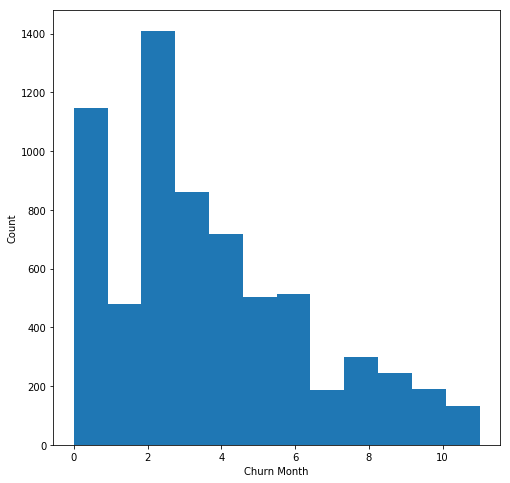

In [46]:
figure, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel("Churn Month")  #x = 12 --> churn didn't occure
ax.set_ylabel("Count")
ax.hist(y, bins = 12);
figure.savefig("y_hist", dpi=300)

#### Since attribute is a categorical variable, it is important to know how many category each feature has. Following code shows this.

In [15]:
categorical_features = ['channel', 'geo', 'carrier', 'profession']


In [16]:
for feature in categorical_features:
    print('Number of categories in feature ' + feature + ' = {:.0f}'.format(len(Counter(X[feature]))))

Number of categories in feature channel = 15
Number of categories in feature geo = 51
Number of categories in feature carrier = 6
Number of categories in feature profession = 43


#### Following figures show the predictive features with respective to the target value. For the sake of visualization, the target value is shown only with two classes. 

In [17]:
def make_plot(category):
    figure, ax = plt.subplots(1,1)
    not_churned = []
    churned = []
    category_list = data_df[category].value_counts().keys()

    for cat in category_list:
        comp = data_df[category] == cat
        A = np.sum(data_df[comp]['diff_date']==12)
        B = np.sum(comp) 
        churned.append(A)                           
        not_churned.append(B-A)
        
    if category == 'profession': 
        category_list = [str(i) for i in category_list]
    
    p1 = plt.barh(category_list, not_churned, align='center', alpha=0.3)
    p2 = plt.barh(category_list, churned, left = not_churned, align='center', alpha=0.3) 
    fig = plt.gcf()
    fig.set_size_inches(8,8)
    plt.legend((p1[0],p2[0]),('churned','not churned'))
    plt.title(category)
    plt.tight_layout()


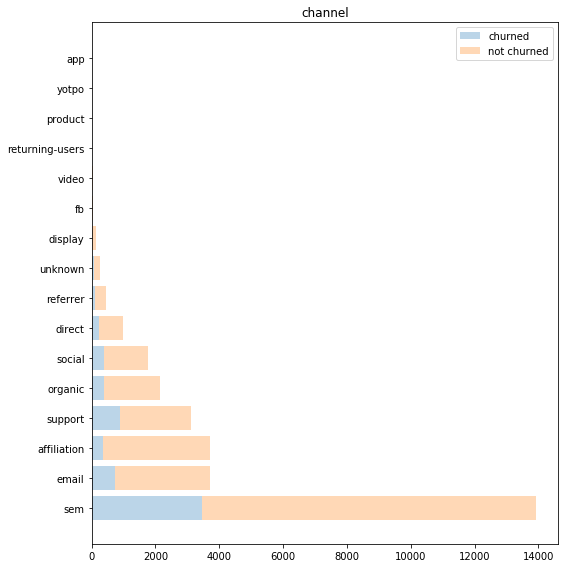

In [18]:
make_plot('channel') 

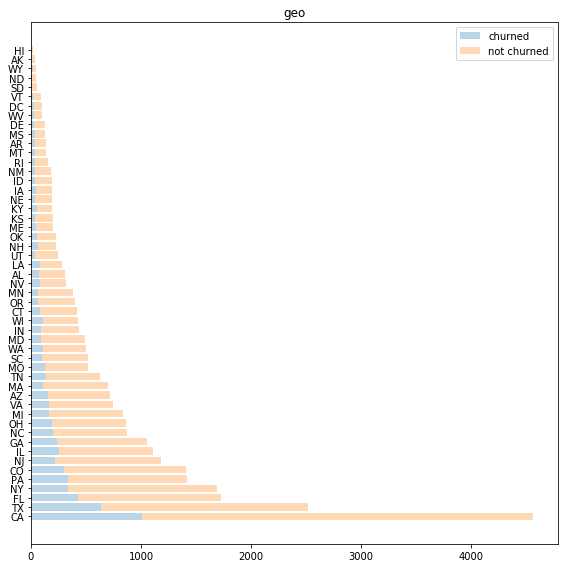

In [19]:
make_plot('geo')

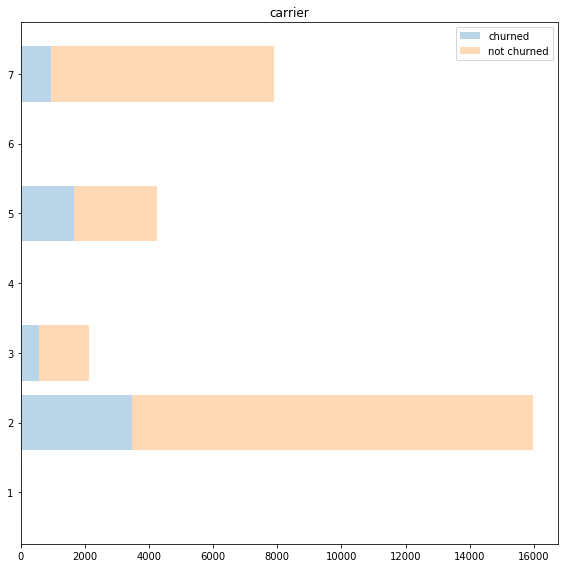

In [20]:
make_plot('carrier')

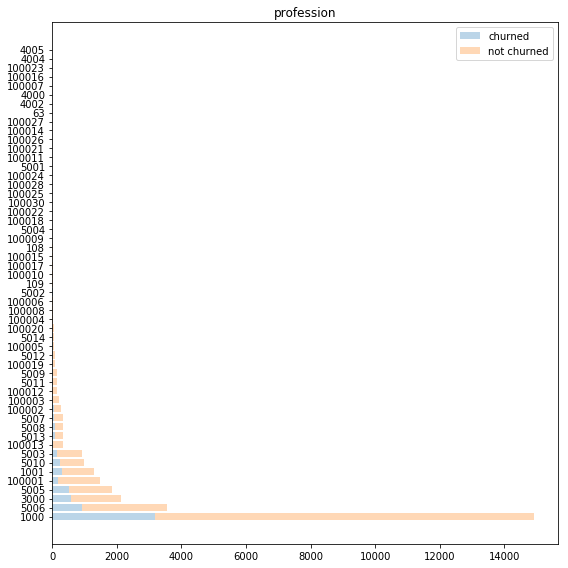

In [21]:
make_plot('profession')

### Let's see breakdow by classes

In [22]:
y.value_counts()

2.0     1410
0.0     1145
3.0      859
4.0      719
6.0      515
5.0      502
1.0      481
8.0      299
9.0      246
10.0     189
7.0      186
11.0     133
Name: diff_date, dtype: int64

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, keys):
        self.keys = keys

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.keys]
    
class DataExtractor(BaseEstimator, TransformerMixin):
    """Extract the categorical and text feature from data.
    """
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        features = np.recarray(shape=(len(data),),
                               dtype=[
                                  ('reason', object), 
                                  ('channel', object), 
                                  ('geo', object), 
                                  ('carrier', object),
                                  ('profession', object)
                               ]
                             )
        
        features['channel'] = data['channel']
        features['geo'] = data['geo']
        features['carrier'] = data['carrier']
        features['profession'] = data['profession']
        
        for i, row in data.iterrows():
            features['reason'][i] = row['cancellation_reason']
        
        return features

In [24]:
class ClassificationModel(object): 
    def __init__(self, X_cat, X_text, class_num):
        global Pipeline, GridSearchCV
        from sklearn.pipeline import Pipeline
        from sklearn.model_selection import GridSearchCV
        
        self.GridSearchCV = GridSearchCV
        self.Pipeline = Pipeline
        self.X_cat = X_cat
        self.X_text = X_text
        self.class_num = class_num
         
    def preproccess(self):
        from sklearn.preprocessing import OneHotEncoder
        from sklearn.compose import ColumnTransformer
        from sklearn.pipeline import FeatureUnion
        
        categorical_one_hot_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
        text_vectorizer = Pipeline(steps=[('vectors', TfidfVectorizer(min_df=50))])
        
        # df['cancellation_reason'].fillna('', inplace=True)
        # df['wordsVect'] = list(vectoriser.fit_transform(df['cancellation_reason']).toarray())

        self.preprocessor = Pipeline([
#             ('data', DataExtractor()),
            ('union', FeatureUnion(
                transformer_list=[
                    ('categorical', Pipeline([
                        ('selector', ItemSelector(keys=self.X_cat)),
                        ('cat_onehot', categorical_one_hot_transformer),
                    ])),
                    
                    # Pipeline for pulling features from the post's subject line
#                     ('text', Pipeline([
#                         ('selector', ItemSelector(keys=X_text)),
#                         ('tfidf', text_vectorizer),
#                     ]))
                ],
                
                # weight components in FeatureUnion
                transformer_weights={
                    'categorical': 0.8,
#                     'text': 0.5
                },
            )
            )
        ])
        
        return self.preprocessor
        
    def LogisticRegressionBuilder(self, param_grid, scoring):
        from sklearn.linear_model import LogisticRegression
        
        lr_pipe = Pipeline(steps=[('preprocessor', self.preproccess()),
                              ('classifier', LogisticRegression(solver='lbfgs', multi_class='multinomial'))])
        
        lr_grid = GridSearchCV(lr_pipe, param_grid, cv=5, iid=False, scoring=scoring, n_jobs=-1)
        
        return lr_grid
    
    def RandomForestBuilder(self, param_grid, scoring):
        from sklearn.ensemble import RandomForestClassifier

        rf_pipe = Pipeline(steps=[('preprocessor', self.preprocessor),
                     ('classifier', RandomForestClassifier(max_features = 'auto'))])

        grid_rf = GridSearchCV(rf_pipe, param_grid, cv=5, scoring=scoring, n_jobs=-1)

        return grid_rf
    
    def SvmClassifier(self, param_grid, scoring):
        from sklearn import svm
        
        svm_pipe = Pipeline(steps=[('preprocessor', self.preprocessor),
                     ('classifier', svm.SVC(kernel='rbf'))])

        grid_svm = GridSearchCV(svm_pipe, param_grid, cv=5, scoring=scoring, n_jobs=-1)

        return grid_svm

In [26]:
X_train, X_test, y_train, y_test= train_test_split(X,y, random_state=4)
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(6684, 5)
(5013, 5)
(1671, 5)


### Since the dataset has class imbalance, the training data is oversampled

In [27]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
X_train_oversample = pd.DataFrame(X_train_oversample, columns = X.keys())

In [28]:
class_names = ['class_'+str(i) for i in range(1,13)]
Counter(y_train_oversample)

Counter({3.0: 1051,
         10.0: 1051,
         4.0: 1051,
         5.0: 1051,
         1.0: 1051,
         8.0: 1051,
         2.0: 1051,
         9.0: 1051,
         0.0: 1051,
         11.0: 1051,
         6.0: 1051,
         7.0: 1051})

Two Classification Models (Logistic Regression and RandomForrest), are tested and optimized for their hyperparameters.The trained classifiers are tested with the set aside test data. The test accuracy for logistic regression model on test set is 0.21 and the accuracy of the RandomForrest model for the test set is 0.28

### Logistic Regression Builder

In [32]:
X_cat = categorical_features
X_text = ['cancellation_reason']

param_grid = {
          'classifier__C': [.01, .1, 1, 10, 100, 1000],
          'classifier__penalty': ['l2']
}

CM = ClassificationModel(X_cat, X_text, 12);
grid_lr = CM.LogisticRegressionBuilder(param_grid, 'accuracy');
grid_lr.fit(X_train, y_train)
print ("Best cross-validation Logistic {:.2f}".format(grid_lr.best_score_))
print ("Best parameters:{}".format(grid_lr.best_params_))

Best cross-validation Logistic 0.23
Best parameters:{'classifier__C': 0.1, 'classifier__penalty': 'l2'}


### Classification Summary for Logistic Regression

In [33]:
print ("Test Accuracy for LR model = {:.4f}".format(grid_lr.score(X_test,y_test)))
print(classification_report(y_test, grid_lr.predict(X_test), target_names=class_names))
Counter(grid_lr.predict(X_train))

Test Accuracy for LR model = 0.2214
              precision    recall  f1-score   support

     class_1       0.26      0.43      0.33       279
     class_2       0.00      0.00      0.00       103
     class_3       0.21      0.69      0.32       359
     class_4       0.11      0.00      0.01       221
     class_5       0.00      0.00      0.00       179
     class_6       0.00      0.00      0.00       122
     class_7       0.00      0.00      0.00       150
     class_8       0.00      0.00      0.00        48
     class_9       0.00      0.00      0.00        81
    class_10       0.00      0.00      0.00        62
    class_11       0.00      0.00      0.00        38
    class_12       0.00      0.00      0.00        29

   micro avg       0.22      0.22      0.22      1671
   macro avg       0.05      0.09      0.06      1671
weighted avg       0.10      0.22      0.13      1671



Counter({2.0: 3515, 4.0: 118, 0.0: 1357, 3.0: 23})

### SVM Builder

In [34]:
param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10],
               'classifier__gamma': [0.001, 0.01, 0.1, 1]
             }
grid_svm = CM.SvmClassifier(param_grid, scoring = 'accuracy')

grid_svm.fit(X_train_oversample, y_train_oversample)
print ("Best cross-validation score SVM {:.2f}".format(grid_svm.best_score_))
print ("Best parameters:{}".format(grid_svm.best_params_))

Best cross-validation score SVM 0.39
Best parameters:{'classifier__C': 10, 'classifier__gamma': 1}


### Classification Summary for SVM

In [37]:
print ("Test Accuracy for SVM model = {:.4f}".format(grid_svm.score(X_test,y_test)))
print(classification_report(y_test, grid_svm.predict(X_test), target_names=class_names))
Counter(grid_svm.predict(X_train))

Test Accuracy for SVM model = 0.1370
              precision    recall  f1-score   support

     class_1       0.32      0.28      0.30       279
     class_2       0.12      0.11      0.11       103
     class_3       0.28      0.16      0.20       359
     class_4       0.17      0.08      0.11       221
     class_5       0.17      0.07      0.10       179
     class_6       0.10      0.07      0.08       122
     class_7       0.11      0.07      0.09       150
     class_8       0.07      0.17      0.09        48
     class_9       0.05      0.05      0.05        81
    class_10       0.05      0.11      0.07        62
    class_11       0.05      0.26      0.08        38
    class_12       0.03      0.21      0.05        29

   micro avg       0.14      0.14      0.14      1671
   macro avg       0.13      0.14      0.11      1671
weighted avg       0.19      0.14      0.15      1671



Counter({3.0: 315,
         10.0: 616,
         4.0: 288,
         8.0: 245,
         7.0: 378,
         11.0: 713,
         6.0: 309,
         0.0: 584,
         9.0: 389,
         1.0: 378,
         2.0: 483,
         5.0: 315})

### RandomForrest Builder

In [40]:
param_grid = {'classifier__max_depth': [10, 20, 50, 100],
              'classifier__max_features': ['auto', 'sqrt'],
              'classifier__n_estimators': [20, 50, 100],
              'classifier__bootstrap': [True, False],
              'classifier__min_samples_split': [2, 5, 10],
              'classifier__min_samples_leaf': [1, 2, 4],
             },
             
grid_rf = CM.RandomForestBuilder(param_grid, scoring = 'accuracy')

grid_rf.fit(X_train_oversample, y_train_oversample)
print ("Best cross-validation score Random Forrest {:.2f}".format(grid_rf.best_score_))
print ("Best parameters:{}".format(grid_rf.best_params_))

Best cross-validation score Random Forrest 0.39
Best parameters:{'classifier__max_depth': 100, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}


### Classification Summary for RandomForrest

In [41]:
print ("Test Accuracy for RF model = {:.4f}".format(grid_rf.score(X_test,y_test)))
print(classification_report(y_test, grid_rf.predict(X_test), target_names=class_names))
Counter(grid_rf.predict(X_train))

Test Accuracy for RF model = 0.1358
              precision    recall  f1-score   support

     class_1       0.36      0.25      0.30       279
     class_2       0.11      0.12      0.11       103
     class_3       0.31      0.15      0.20       359
     class_4       0.18      0.09      0.12       221
     class_5       0.16      0.07      0.10       179
     class_6       0.10      0.07      0.09       122
     class_7       0.11      0.07      0.09       150
     class_8       0.06      0.17      0.09        48
     class_9       0.04      0.05      0.05        81
    class_10       0.05      0.13      0.07        62
    class_11       0.06      0.29      0.09        38
    class_12       0.03      0.24      0.06        29

   micro avg       0.14      0.14      0.14      1671
   macro avg       0.13      0.14      0.11      1671
weighted avg       0.20      0.14      0.15      1671



Counter({3.0: 336,
         9.0: 420,
         4.0: 294,
         8.0: 249,
         7.0: 396,
         10.0: 583,
         11.0: 706,
         6.0: 304,
         0.0: 563,
         1.0: 396,
         2.0: 464,
         5.0: 302})

### RMSE of predicted months

In [42]:
y_pred = grid_lr.predict(X_test)
rmse = (sum((y_pred-y_test.values)**2))**0.5
print ("Root Mean Square Error Logistic Regression:{}".format(rmse))

Root Mean Square Error Logistic Regression:142.55525244620065


In [43]:
y_pred = grid_rf.predict(X_test)
rmse = (sum((y_pred-y_test.values)**2))**0.5
print ("Root Mean Square Error RandomForrest:{}".format(rmse))

Root Mean Square Error RandomForrest:187.0935594829496


### Predicted probabilities for the 12 classes using the two models

In [44]:
pd.DataFrame(grid_lr.predict_proba(X_test)[0:10], columns = range(1,13))

,1,2,3,4,5,6,7,8,9,10,11,12
0,0.060960,0.046068,0.177083,0.129344,0.123692,0.094476,0.108709,0.041379,0.061659,0.064346,0.055347,0.036939
1,0.191684,0.096426,0.175066,0.090028,0.096193,0.127489,0.062732,0.024067,0.045361,0.052077,0.026617,0.012259
2,0.153577,0.101582,0.224608,0.103688,0.105898,0.081693,0.079544,0.021342,0.040951,0.039658,0.035784,0.011675
3,0.088158,0.059006,0.146097,0.128702,0.128248,0.072058,0.115862,0.043401,0.070974,0.061796,0.048916,0.036782
4,0.219538,0.085965,0.300420,0.129058,0.076185,0.076921,0.051838,0.012302,0.017893,0.013528,0.008487,0.007865
5,0.219045,0.123161,0.191188,0.111361,0.080374,0.067179,0.050216,0.032094,0.036391,0.046880,0.030450,0.011662
6,0.256455,0.079283,0.244963,0.123658,0.099716,0.071231,0.047366,0.015217,0.025608,0.016978,0.011654,0.007871
7,0.326748,0.089718,0.184812,0.126241,0.092377,0.047605,0.060309,0.012268,0.025994,0.016480,0.010507,0.006942
8,0.273817,0.070929,0.241261,0.115132,0.106418,0.062460,0.057858,0.008962,0.025263,0.017761,0.012599,0.007541
9,0.201165,0.073916,0.183657,0.094853,0.085723,0.087869,0.079432,0.028692,0.052975,0.045495,0.046977,0.019246


In [45]:
pd.DataFrame(grid_rf.predict_proba(X_test)[0:10], columns = range(1,13))

,1,2,3,4,5,6,7,8,9,10,11,12
0,0.041503,0.000000,0.022106,0.091299,0.056740,0.041516,0.127775,0.142093,0.191783,0.000000,0.285185,0.000000
1,0.000000,0.000000,0.124969,0.116071,0.000000,0.000000,0.000000,0.000000,0.000000,0.758960,0.000000,0.000000
2,0.017084,0.032404,0.140212,0.015863,0.234002,0.111957,0.331285,0.000000,0.117194,0.000000,0.000000,0.000000
3,0.021319,0.037553,0.052187,0.086872,0.062852,0.041858,0.138405,0.098081,0.101458,0.114852,0.097211,0.147352
4,0.027000,0.010000,0.862000,0.005000,0.070000,0.026000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.185000,0.077067,0.218375,0.064861,0.013000,0.030000,0.003056,0.364066,0.000000,0.039576,0.005000,0.000000
6,0.091703,0.048606,0.125035,0.126083,0.167343,0.051938,0.025650,0.181762,0.076786,0.013000,0.000000,0.092094
7,0.221916,0.442808,0.078130,0.113638,0.000000,0.084570,0.058938,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.500281,0.000000,0.375212,0.000000,0.124507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.002941,0.000000,0.981765,0.000000,0.000000,0.002353,0.002941,0.010000,0.000000


## Conclusion/future work:

- I explored different algorithms based on dataset and Random Forest is outperforming than the others.
- I added cancellation reasons as word vectors in features and tried to improve model performance but it was not adding much value but we can explore other word embeddings to improve model performace.
- There is a class imbalance in dataset, after doing oversampling, model performance improved slightly.  
- Also, because of small amount of data, I couldn't explore deep learning based models but if we collect more data then we can improve model performace using different suitable architecture. 